### Sobel Filter Code

In [1]:
import numpy as np # scientific computing
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg # reading images
from skimage.color import rgb2gray # converting rgb images to grayscale
import cv2  # computer vision library

In [2]:
img1 = rgb2gray(mpimg.imread('edge4.jpg'))

In [3]:
def cross_correlate2D(img, mask):
    n_r, n_c = img.shape
    # Compute row and column offsets
    mask_r, mask_c = mask.shape
    r_offset = mask_r // 2 - (mask_r % 2 == 0)
    c_offset = mask_c // 2 - (mask_c % 2 == 0)
    # Apply zero-padding 
    padded_img = np.pad(img, ((r_offset, r_offset + (mask_r % 2 == 0)),
                              (c_offset, c_offset + (mask_c % 2 == 0))))
    # Perform 2D cross-correlation
    output = np.zeros((n_r, n_c))
    for row in range(r_offset, r_offset + n_r):
        for col in range(c_offset, c_offset + n_c):
            output[row - r_offset, col - c_offset] = np.sum(
                mask *
                padded_img[row - r_offset: row + r_offset + (mask_r % 2 == 0) + 1, 
                           col - c_offset: col + c_offset + (mask_c % 2 == 0) + 1]
            )
    return output

In [4]:
def sobel(img):
    mask_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    mask_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    edge_x = cross_correlate2D(img, mask_x) / 6
    edge_y = cross_correlate2D(img, mask_y) / 6
    gradient_magnitudes = np.sqrt(edge_x ** 2 + edge_y ** 2)
    gradient_magnitudes *= 255 / np.max(gradient_magnitudes)
    gradient_directions = np.arctan2(edge_y, edge_x)
    return edge_x, edge_y, gradient_magnitudes, gradient_directions

### Sticks Filter Code

In [5]:
def getSticks(i):
    stick1 = np.array([[0, 0, 1, 0, 0],
                       [0, 0, 1, 0, 0],
                       [0, 0, 1, 0, 0],
                       [0, 0, 1, 0, 0],  
                       [0, 0, 1, 0, 0]])

    stick2 = np.array([[0, 0, 0, 1, 0],
                       [0, 0, 0, 1, 0],
                       [0, 0, 1, 0, 0],
                       [0, 1, 0, 0, 0],  
                       [0, 1, 0, 0, 0]])

    stick3 = np.array([[0, 0, 0, 0, 1],
                       [0, 0, 0, 1, 0],
                       [0, 0, 1, 0, 0],
                       [0, 1, 0, 0, 0],  
                       [1, 0, 0, 0, 0]])

    stick4 = np.array([[0, 0, 0, 0, 0],
                       [0, 0, 0, 1, 1],
                       [0, 0, 1, 0, 0],
                       [1, 1, 0, 0, 0],  
                       [0, 0, 0, 0, 0]])

    stick5 = np.array([[0, 0, 0, 0, 0],
                       [0, 0, 0, 0, 0],
                       [1, 1, 1, 1, 1],
                       [0, 0, 0, 0, 0],  
                       [0, 0, 0, 0, 0]])

    stick6 = np.array([[0, 0, 0, 0, 0],
                       [1, 1, 0, 0, 0],
                       [0, 0, 1, 0, 0],
                       [0, 0, 0, 1, 1],  
                       [0, 0, 0, 0, 0]])

    stick7 = np.array([[1, 0, 0, 0, 0],
                       [0, 1, 0, 0, 0],
                       [0, 0, 1, 0, 0],
                       [0, 0, 0, 1, 0],  
                       [0, 0, 0, 0, 1]])

    stick8 = np.array([[0, 1, 0, 0, 0],
                       [0, 1, 0, 0, 0],
                       [0, 0, 1, 0, 0],
                       [0, 0, 0, 1, 0],
                       [0, 0, 0, 1, 0]])
    sticks = np.array([stick1, stick2, stick3, stick4, stick5, stick6, stick7, stick8])/5
    return sticks[i]
    
    

In [6]:
def sticks_filter(image):
    # Initialize the sticks map
    n = 5
    s_i = 8  
      
    T = np.zeros_like(image, dtype=np.float32)
    averageKernel = np.ones((n, n))/(n*n)
    
    # Apply the sticks filter
    for i in range(s_i):
                
        # Compute the average intensity of the stick and the neighboring pixels     
        mu_si = cv2.filter2D(image, -1, getSticks(i))
        I_n = cv2.filter2D(image, -1, averageKernel)

        # Compute the maximum contrast response
        T = np.maximum(T, mu_si - I_n)

    return T

### Other non-related code

In [7]:
def gaussian_blur(sigma, k=2):
    """
    Generates a Gaussian Blur Filter with shape (2k + 1, 2k + 1), with
    the specified standard deviation.
    Args:
        sigma: The standard deviation of the Gaussian Blur
        k: The parameter that determines the shape of the filter (2 by default)
    Returns:
        G: The resulting Gaussian Blur Filter 
    """
    x, y = np.mgrid[-k: k + 1, -k: k + 1]
    G = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2)) / 2 * np.pi * sigma ** 2
    return G

def non_max_suppression(gradient_magnitudes, gradient_directions):
    """
    Implements the Non-Maximum Suppression algorithm to thin out the
    edges described as gradient magnitudes.
    Args:
        gradient_magnitudes: Edge intensities
        gradient_directions: Edge directions (angles in Radians)
    output:
        result: The processed edge intensities 
    """
   
    #INSER YOUR CODE HERE
    output = np.zeros_like(gradient_magnitudes)
    angle = np.degrees(gradient_directions)
    angle[angle < 0] += 180  # force angles into 4 sectors
    
    # Apply zero-padding to the gradient_magnitudes
    gradient_magnitudes1 = np.pad(gradient_magnitudes, 1, mode='constant')
       
    for i in range(1, gradient_magnitudes1.shape[0]-1):
        for j in range(1, gradient_magnitudes1.shape[1]-1):
            current_angle = angle[i-1, j-1]
            
            if (current_angle < 22.5) or (157.5 <= current_angle <= 180):
                before = gradient_magnitudes1[i, j-1]
                after = gradient_magnitudes1[i, j+1]
            elif (22.5 <= current_angle < 67.5):
                before = gradient_magnitudes1[i+1, j-1]
                after = gradient_magnitudes1[i-1, j+1]
            elif (67.5 <= current_angle < 112.5):
                before = gradient_magnitudes1[i-1, j]
                after = gradient_magnitudes1[i+1, j]
            elif (112.5 <= current_angle < 157.5):
                before = gradient_magnitudes1[i-1, j-1]
                after = gradient_magnitudes1[i+1, j+1]
            if (gradient_magnitudes1[i,j] >= before) and (gradient_magnitudes1[i,j] >= after):
                output[i-1,j-1] = gradient_magnitudes1[i,j]                    
    
    return output

def plot_results1(result1, result2, result3, result4, figsize_, titles, save=False, cmap4='viridis', dimension_x=2, dimension_y=2):
    fig, axs = plt.subplots(dimension_x, dimension_y, figsize=figsize_)
    
    indicies2x2 = [(0, 0), (0, 1), (1, 0), (1, 1)]
    
    if dimension_x==1 and dimension_y==2:
        for i in range(2):
            axs[i].set_title(titles[i])
            axs[i].axis('off')
            axs[i].imshow([result1, result2][i], cmap='gray')
    else:
        for i in range(4):
            axs[indicies2x2[i]].set_title(titles[i])
            axs[indicies2x2[i]].axis('off')
            axs[indicies2x2[i]].imshow([result1, result2, result3, result4][i], cmap=['gray', 'gray', 'gray', cmap4][i])
   
    if save:
        plt.savefig(method + '_results' + img_number + '.png')
    plt.show()

### Resulting Images

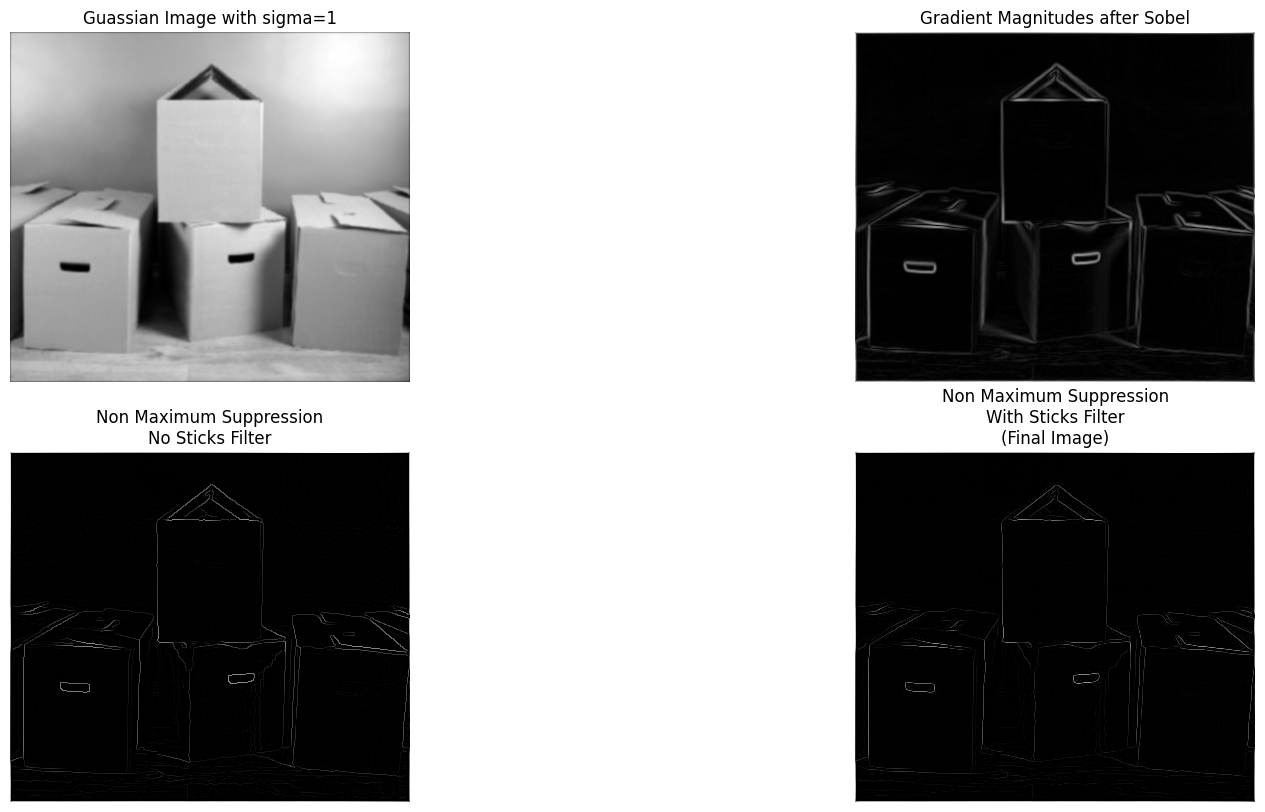

In [8]:
blurred_image = cross_correlate2D(img1, gaussian_blur(1))
_, _, gradient_magnitudes, gradient_directions = sobel(blurred_image)
non_max_supp_image = non_max_suppression(gradient_magnitudes, gradient_directions)
non_max_sticks_image = non_max_suppression(sticks_filter(non_max_supp_image), gradient_directions)

titles = ['Guassian Image with sigma=1', 'Gradient Magnitudes after Sobel', 'Non Maximum Suppression\nNo Sticks Filter', 'Non Maximum Suppression\nWith Sticks Filter\n(Final Image)']
plot_results1(blurred_image, gradient_magnitudes, non_max_supp_image, non_max_sticks_image, (20, 10), titles, False, 'gray', 2, 2)

